In [8]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit

In [23]:
# The functions below can be used to initialise a 2D
# grid of spins, and then let it evolve towards a more
# likely configuration. See further details in
# http://web.phys.ntnu.no/~ingves/Teaching/TFY4235/Download/TFY4235_Slides_2015.pdf
# under Metropolis Monte-Carlo algorithm.

def initialise(N):
    # This function initialises a grid of size N x N
    # where each number is either 1 or -1
    # (corresponding to spin up or down)
    spins = np.ones((N, N), dtype = np.int32)
    for i in range(N):
        for j in range(N):
            r = np.random.random()
            if r < 0.5:
                spins[i,j] = -1
    return spins


@jit(nopython = True)
def dH(i, j, spins):
    # This function calculates the change in energy
    # from flipping a spin
    Nx = spins.shape[0]
    Ny = spins.shape[1]
    J = 1
    s = -spins[i,j]
    return -J * s * (
        spins[i-1, j] + spins[(i+1) % Nx, j] +
        spins[i, j-1] + spins[i, (j+1) % Ny] )


# This function receives a considerable speedup
# from just-in-time compilation with numba, as
# it contains a for-loop. The effect of jit-compiling
# the function dH above isn't as large, but it is
# required as one cannot call a non-compiled function
# from within a compiled function.
@jit(nopython = True)
def sweep(spins, T):
    # This function carries out a "sweep" over the grid,
    # in the sense that it tries to flip each spin once
    # on average, rejecting the flip with a certain probability
    # which depends on temperature and change in energy
    for i in range(spins.size):
        i = np.random.randint(0, spins.shape[0])
        j = np.random.randint(0, spins.shape[1])
        r = np.random.random()
        w = np.exp(-dH(i,j,spins)/T)
        if w > r:
            spins[i,j] = -spins[i,j]
    return spins


def average(spins):
    return np.sum(spins) / spins.size


def run(Nspins, Nsweeps, T):
    # This function carries out one simulation:
    # Initialise a random grid
    # Carry out a number of sweeps, until the system
    # can be assumed to have reached equilibrium
    # Then return the average spin
    # (which is proportional to the bulk magnetisation)
    spins = initialise(Nspins)
    for i in range(Nsweeps):
        spins = sweep(spins, T)
    return average(spins)

In [24]:
# Set up grid size, then run a bunch of simulations
# for increasing temperature
Nspins  = 40
Nsweeps = 500
Temps   = np.linspace(0.1, 2, 250)
Moments = []

iout = 0
for i,T in enumerate(Temps):
    # Primitive progress bar
    if i > iout:
        print('=', end = '')
        iout += len(Temps) / 50
    Moments.append(run(Nspins, Nsweeps, T))

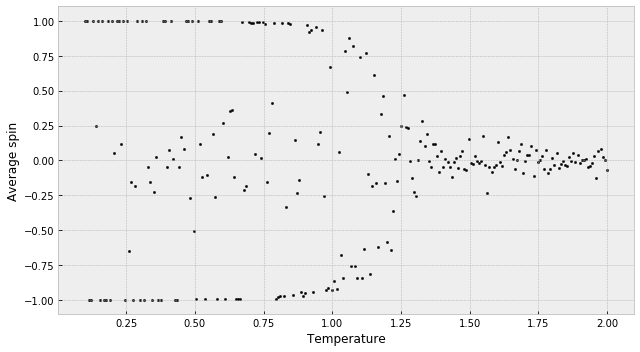

In [22]:
# Plot of average spin agains temperature
# reveals a pitchfork bifurcation.
fig = plt.figure(figsize = (9,5))
plt.scatter(Temps, Moments, c = 'k', s = 5)
plt.xlabel('Temperature')
plt.ylabel('Average spin')
plt.tight_layout()